スペクトラム拡散変調のシミュレーション
===

<img src='./imgsrc/CDMA変調.drawio.png'>

In [2]:
# import
import numpy as np
import matplotlib.pyplot as plt
import sys

np.set_printoptions(precision=4, suppress=True, floatmode="maxprec_equal")
plt.rcParams['figure.figsize'] = (12,4)

In [3]:
# データ生成器

def rndCode(codeSize, Type):
    """
    codeSize: 生成するランダム系列の大きさ（行数ｘ列数）を指定
    Type: タイプ指定 0: [0,1], 1: [-1, 1]
    """
    
    rndCode = np.random.randn(*codeSize)
    
    if rndCode.ndim > 2:
        sys.exit()
    
    dataSize = rndCode.shape
    if len(dataSize) == 1:
        sys.exit()
    
    if Type == 0:
        rndCode = np.where(rndCode <= 0, 0, 1)
    else:
        rndCode = np.where(rndCode <= 0, -1, 1)
    
    return rndCode

In [4]:
# BPSK変調器
def bpskMod(data):
    """
    data: 列ベクトル
    bpskSymbol： 列ベクトル
    """
    bpskSymbol = data.copy()
    np.place(bpskSymbol, bpskSymbol == 0, -1)
    
    return bpskSymbol

In [5]:
# 送信機
Ndata = 10 # データ数
SNRdB = 20 # 雑音比

Nchip = 100
Lss = Ndata * Nchip

Delay = np.array([[0,10]])
Npath = max(Delay.shape)

data = rndCode([Ndata, 1], 0)
bpskSymbol = bpskMod(data)
Nsymbol = max(bpskSymbol.shape)

# 拡散系列
spCode = rndCode([Nchip, 1], 1)
ssSig = spCode * bpskSymbol.T
ssSig = ssSig.flatten('F')

In [6]:
# 送信データ
data.T

array([[1, 0, 0, 0, 1, 1, 0, 1, 0, 0]])

In [7]:
# ガウス雑音生成

def awgn(Pn, rn, cn):
    """
    Pn: 雑音電力
    ｒｎ: 行数
    cn: 列数
    """
    n = np.random.randn(rn, cn) + 1j*np.random.randn(rn, cn)
    n = n * np.sqrt(Pn/2)
    
    return n

In [8]:
# 遅延発生器
def delayGen(delayVec, ssSigMat):
    sigMat = ssSigMat.copy()
    Nsig = delayVec.shape[1]
    
    if Nsig != sigMat.shape[1]:
        sys.exit(1)
    
    for co in range(0, Nsig):
        if delayVec[0,co] > 0:
            roll_num = delayVec[0][co]
            sigMat[:,co] = np.roll(sigMat[:,co],roll_num)
            sigMat[:roll_num, co] = 0
            
    return sigMat



In [9]:
# 選択性フェージング

## 遅延追加
ssSigMat = ssSig.reshape(ssSig.size, 1) * np.ones((1,Npath))
ssSigMatDelayed = delayGen(Delay, ssSigMat)

chOut = ssSigMatDelayed @ np.ones([Npath,1])

# 雑音印加
Pn = 10**(-SNRdB/10) * Nchip
rSig = chOut + awgn(Pn, Lss, 1)

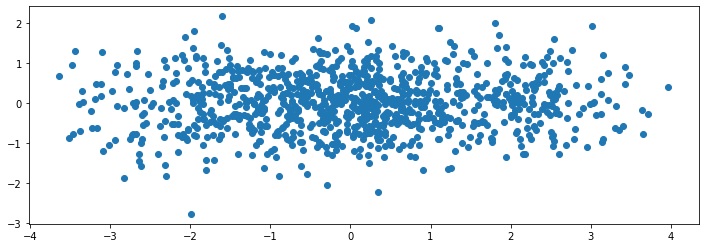

In [10]:
plt.scatter(rSig.real, rSig.imag)

In [11]:
# 相関器
def correlator(w, rSig):
    """
    w: 重み係数
    sig:　入力信号
    """
    sig = rSig.copy()
    
    sizeW = w.shape
    Lw = sizeW[0] # 100
    Nw = sizeW[1] # 1
    corIn = np.vstack([sig, np.zeros((Lw,1))]) # 1100 x 1
    corOut = np.zeros((len(sig), Nw), dtype="complex") # 1000x1
    
    for co in range(0, max(corOut.shape)):
        corOut[co, :] = w.conj().T @ corIn[co:(co + Lw)]

    return corOut

In [12]:
# BPSK復調器
def bpskDem(rSig):
    """
    rSig : 受信信号
    rData:　受信データ
    """
    rData = np.ones(rSig.shape)
    rData[rSig < 0] =  0
    
    return rData

In [13]:
corOut = correlator(spCode, rSig)
corOut_rshp = corOut.reshape(Nchip, Nsymbol, order='F').copy()
rData = np.array([bpskDem(corOut_rshp[0,:])])

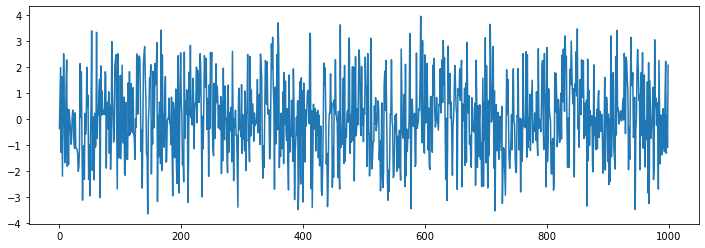

In [25]:
# IQデータ 実数部
plt.plot(rSig.real)

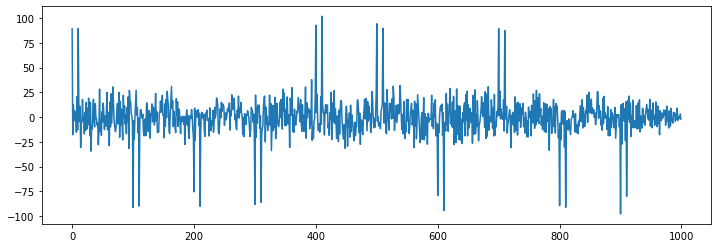

In [15]:
# 自己相関を通すことによりデータ復調が顕著に表示
plt.plot(corOut.real)

In [60]:
rData

array([[0., 0., 1., 1., 0., 0., 1., 1., 1., 1.]])

In [46]:
# BER比較器
def ber(data1, data2):
    BER = np.sum(np.abs(data1-data2))/max(data1.shape)
    return BER

In [47]:
# ビットエラーレート（BER）の測定
ber(data, rData.T)

0.0